<a href="https://colab.research.google.com/github/bboyeong/2022-2-Euron-Study-Assignment/blob/master/%EC%9C%A0%EB%9F%B03_1%2C2%EC%A3%BC%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
dataset=pd.read_csv('car_evaluation.csv')
dataset.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


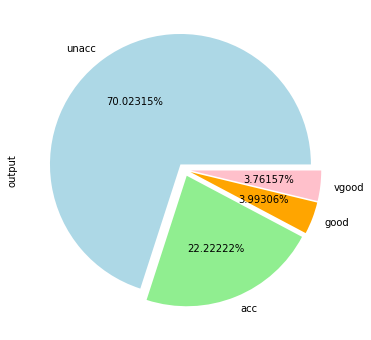

In [ ]:
fig_size=plt.rcParams["figure.figsize"]
fig_size[0]=8
fig_size[1]=6
plt.rcParams["figure.figsize"]=fig_size
dataset.output.value_counts().plot(kind="pie", autopct='%0.05f%%', colors=['lightblue', 'lightgreen','orange','pink'],explode=(0.05, 0.05, 0.05, 0.05))


In [ ]:
#범주형 데이터 -> dataset[category] -> 넘파이 배열 -> 텐서
categorical_columns=['price', 'maint', 'doors', 'persons','lug_capacity','safety']
for category in categorical_columns:
  dataset[category]=dataset[category].astype('category')

price=dataset['price'].cat.codes.values
maint=dataset['maint'].cat.codes.values
doors=dataset['doors'].cat.codes.values
persons=dataset['persons'].cat.codes.values
lug_capacity=dataset['lug_capacity'].cat.codes.values
safety=dataset['safety'].cat.codes.values


categorical_data=np.stack([price, maint, doors, persons, lug_capacity, safety],1)
categorical_data[:10]

array([[3, 3, 0, 0, 2, 1],
       [3, 3, 0, 0, 2, 2],
       [3, 3, 0, 0, 2, 0],
       [3, 3, 0, 0, 1, 1],
       [3, 3, 0, 0, 1, 2],
       [3, 3, 0, 0, 1, 0],
       [3, 3, 0, 0, 0, 1],
       [3, 3, 0, 0, 0, 2],
       [3, 3, 0, 0, 0, 0],
       [3, 3, 0, 1, 2, 1]], dtype=int8)

In [ ]:
categorical_data=torch.tensor(categorical_data, dtype=torch.int64)
categorical_data[:10]

tensor([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        [3, 3, 0, 0, 1, 1],
        [3, 3, 0, 0, 1, 2],
        [3, 3, 0, 0, 1, 0],
        [3, 3, 0, 0, 0, 1],
        [3, 3, 0, 0, 0, 2],
        [3, 3, 0, 0, 0, 0],
        [3, 3, 0, 1, 2, 1]])

In [ ]:
outputs=pd.get_dummies(dataset.output)
outputs=outputs.values
outputs=torch.tensor(outputs).flatten()
print(categorical_data.shape)
print(outputs.shape)

torch.Size([1728, 6])
torch.Size([6912])


In [ ]:
#워드 입베딩을 위해, n차원으로 변환
categorical_column_sizes=[len(dataset[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes=[(col_size, min(50,(col_size +1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]


In [ ]:
#데이터셋 분리
total_records=1728
test_records=int(total_records*.2)

categorical_train_data=categorical_data[:total_records-test_records]
categorical_test_data=categorical_data[total_records-test_records:total_records]
train_outputs=outputs[:total_records-test_records]
test_outputs=outputs[total_records-test_records:total_records]

In [ ]:
print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

1383
1383
345
345


In [ ]:
class Model(nn.Module):
  #파라미터와 신경망 초기화 
  #self, 범주형 칼럼의 임베딩 크기, 출력층의 크기, 모든 계층에 대한 목록, 드롭아웃
  def __init__(self, embedding_size, output_size, layers, p=0.4):
    super().__init__()
    self.all_embeddings=nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
    self.embedding_dropout=nn.Dropout(p)

    all_layers=[]
    num_categorical_cols=sum((nf for ni, nf in embedding_size))
    input_size=num_categorical_cols

    # 모델 네트워크 = linear 선형 + ReLU 활성화 함수 + BatchNorm1d 배치 정규화 + dropout 과적합방지
    for i in layers:
      all_layers.append(nn.Linear(input_size,i))
      all_layers.append(nn.ReLU(inplace=True))
      all_layers.append(nn.BatchNorm1d(i))
      all_layers.append(nn.Dropout(p))
      input_size=i

    all_layers.append(nn.Linear(layers[-1], output_size))
    self.layers=nn.Sequential(*all_layers)

  #연산 진행
  def forward(self, x_categorical):
    embeddings=[]
    for i, e in enumerate(self.all_embeddings):
      embeddings.append(e(x_categorical[:,i]))
      x=torch.cat(embeddings,1)
      x=self.embedding_dropout(x)
      x=self.layers(x)
      return x


In [ ]:
model=Model(categorical_embedding_sizes, 4,[200,100,50], p=0.4)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(4, 2)
    (2): Embedding(4, 2)
    (3): Embedding(3, 2)
    (4): Embedding(3, 2)
    (5): Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)


In [ ]:
#분류-손실함수-크로스 엔트로피 , 옵티마이저-adam
loss_function=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
if torch.cuda.is_available():
  device=torch.device('cuda')
else:
  device=torch.device('cpu')

In [ ]:
#모델 학습
epochs=500
aggregated_losses=[]
train_outputs=train_outputs.to(device=device, dtype=torch.int64)

for i in range(epochs):
  i+=1
  y_pred=model(categorical_train_data).to(device)
  single_loss=loss_function(y_pred, train_outputs)
  aggregated_losses.append(single_loss)  #오차를 추가

  if i%25==1:
    print(f'epoch:{i:3} loss:{single_loss.item():10.8f}')

  optimizer.zero_grad() #gradeint 0으로 만듬
  single_loss.backward()  #가중치 업데이트 위해
  optimizer.step() #기울기 업데이트

print(f'epoch:{i:3} loss:{single_loss.item():10.10f}')

1383


RuntimeError: ignored

의문

In [ ]:
#테스트로 모델 예측
test_outputs=test_outputs.to(device=device, dtype=torch.int64)
with torch.no_grad():
  y_val=model(categorical_test_data)
  loss=loss_function(y_val, test_outputs)
print(f'Loss:{loss:.8f}')

RuntimeError: ignored

In [ ]:
#예측 확인 
print(y_val[:5])

In [ ]:
#가장큰 값을 갖는 인덱스 확인
y_val=np.argmax(y_val, axis=1)
print(y_val[:5])

In [ ]:
#정확도 확인
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(test_outputs, y_val))
print(classification_report(test_outputs, y_val))
print(accuracy_score(test_outputs, y_val))

#4단원 필사

In [ ]:
class Net(torch.nn.Module):
  def __init__(self, n_feature, n_hidden, n_output):
    super(Net,self).__init__()
    self.hidden=torch.nn.Linear(n_feature, n_hidden)
    self.relu=torch.nn.ReLu(inplace=True)
    self.out=torch.nn.Linear(n_hidden,n_output)
    self.softmax=torch.nn.Softmax(dim=n_output)

  def forward(self, x):
    x=self.hidden(x)
    x=self.relu(x)
    x=self.out(x)
    x=self.softmax(x)
    return x

In [ ]:
loss_fn=torch.nn.MSELoss(reduction='sum')
y_pred=model(x)
loss=loss_fn(y_pred, y)

In [ ]:
loss=nn.CrossEntropyLoss()
input=torch.randn(5,6,requires_grad=True)
target=torch.empty(3,dtype=torch.long).random_(5)
output=loss(input, target)
output.backward()

In [ ]:
class DropoutModel(torch.nn.Module):
  def __init__(self):
    super(DropoutModel, self).__init__()
    self.lyaer1=torch.nn.Linear(784, 1200)
    self.dropout1=torch.nn.Dropout(0.5)
    self.layer2=torch.nn.Linear(1200, 1200)
    self.dropout2=torch.nn.Dropout(0.5)
    self.layer3=torch.nn.Linear(1200,10)

  def forward(self, x):
    x=F.relu(self.layer1(x))
    x=self.dropout1(x)
    x=F.relu(self.layer2(x))
    x=self.dropout2(x)
    return self.layer3(x)

In [ ]:
#미니배치경사하강법


class CustomDataset(Dataset):
  def __init__(self):
    self.x_data=[[1,2,3],[4,5,6],[7,8,9]]
    self.y_data=[[12],[18],[11]]

    def__len__(self):
      return len(self.x_data)

    def __getitem(self, idx):
      x=torch.FloatTensor(self.x_data[idx])
      y=torch.FloatTensor(self.y_data[idx])

      return x,y


dataset=CustomDataset()
dataloader=DataLoader(
    dataset, batch_size=2, shuffle=True,
)

#유런 3주차 예습과제

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms      #데이터 전처리를 위해
from torch.utils.data import Dataset, DataLoader

In [ ]:
device=torch.device("cude:0" if torch.cuda.is_available() else "cpu")

check

In [ ]:
train_dataset=torchvision.datasets.FashionMNIST('/content/drive/MyDrive/chap05/data/catanddog/train', download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset=torchvision.datasets.FashionMNIST('/content/drive/MyDrive/chap05/data/catanddog/test',download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))  #이미지를 텐서(0~1)로 변경

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/chap05/data/catanddog/train/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/chap05/data/catanddog/train/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/chap05/data/catanddog/train/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/chap05/data/catanddog/train/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/chap05/data/catanddog/train/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/chap05/data/catanddog/train/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/chap05/data/catanddog/train/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/chap05/data/catanddog/train/FashionMNIST/raw



  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/chap05/data/catanddog/test/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/chap05/data/catanddog/test/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/chap05/data/catanddog/test/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/chap05/data/catanddog/test/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/chap05/data/catanddog/test/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/chap05/data/catanddog/test/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/chap05/data/catanddog/test/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/chap05/data/catanddog/test/FashionMNIST/raw



In [ ]:
#메모리로 불러오기 위해 데이터로더에 전달
#torch.utils.data.DataLoader()를 사용하여 원하는 크기의 배치 단위로 데이터를 불러오거나, 순서shuffle가능
train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=100)

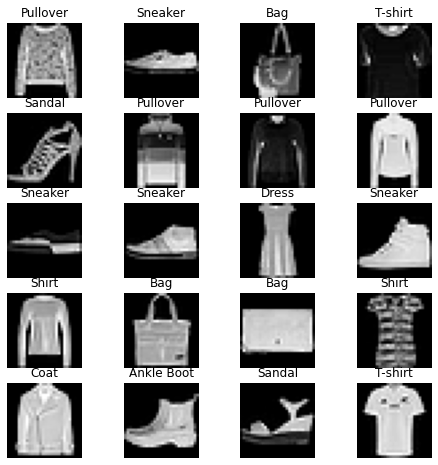

In [ ]:
labels_map={0:'T-shirt',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag',9:'Ankle Boot'}

fig=plt.figure(figsize=(8,8))
columns=4;
rows=5;

for i in range(1,columns*rows+1):
  img_xy=np.random.randint(len(train_dataset));
  img=train_dataset[img_xy][0][0,:,:]
  fig.add_subplot(rows,columns,i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')

In [ ]:
#걍 심층신경망
class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN,self).__init__()
    self.fc1=nn.Linear(in_features=784,out_features=256)
    self.drop=nn.Dropout(0.25)
    self.fc2=nn.Linear(in_features=256,out_features=128)
    self.fc3=nn.Linear(in_features=128,out_features=10)

    def forward(self, input_data):
      out=input_data,view(-1,784)
      out=F.relus(self,fc1(out))
      out=self.drop(out)
      out=F.relu(self.fc2(out))
      out=self.fc3(out)
      return out

In [ ]:
learning_rate=0.001;
model=FashionDNN();
model.to(device)

criterion=nn.CrossEntropyLoss();
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


심층 신경망을 이용한 모델 학습

✅아래 outputs=model(train)

In [ ]:
num_epochs=5
count=0
loss_init=[]
iteration_list=[]
accuracy_list=[]

predictions_list=[]
labels_list=[]

for epoch in range(num_epochs):
  for images, labels in train_loader:
      images,labels=images.to(device), labels.to(device)

      train=Variable(images.view(100,1,28,28))
      labels=Variable(labels)


      outputs=model(train)   #학습데이터를 모델에 적용
      loss=criterion(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      count+=1


      if not(count % 50):
        total=0
        correct=0

        for images,labels in test_loader:
          images,labels=images.to(device), labels.to(device)
          labels_list.append(labels)
          test=Variable(images.view(100,1,28,28))
          outputs=model(test)
          predictions=torch.max(outputs,1)[1].to(device)
          predictions_list.append(predictions)
          correct+=(predictions==labels).sum()
          total+=len(labels)


        accuracy=correct*100/total
        loss_list.append(loss.data)
        iteration_list.append(count)
        accuracy_list.append(accuracy)

      if not(count% 500):
        print("iteration:{}, loss:{}. accuracy:{}%".format(count, loss.data, accuracy))

NotImplementedError: ignored

합성곱 네트워크 생성

In [ ]:
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    self.layer1=nn.Sequential(   
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), #합성곱 연산을 통해서 이미지의 특징을 추출한다. 커널로...
        nn.BatchNorm2d(32), #평균과 분산을 이용하여 정규화함. 
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #이미지 크기를 축소
    )

    self.layer2=nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),  #입력채널수_흑백컬러, 출력채널, 커널크기, 패딩(주위를 0으로 채움)
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.fc1=nn.Linear(in_features=64*6*6, out_features=600) #이미지 형태 데이터를 배열 형태로 변환하여 작업해야 함. 
    self.drop=nn.Dropout2d(0.25)
    self.fc2=nn.Linear(in_features=600, out_features=120)
    self.fc3=nn.Linear(in_features=120, out_features=10)


  def forward(self,x):
    out=self.layer1(x)
    out=self.layer2(out)
    out=out.view(out.size(0),-1)
    out=self.fc1(out)
    out=self.drop(out)
    out=self.fc2(out)
    out=self.fc3(out)

    return out

In [ ]:
learning_rate=0.001;
model=FashionCNN();
model.to(device)
criterion=nn.CrossEntropyLoss();
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [ ]:
num_epochs=5
count=0
loss_list=[]
iteration_list=[]
accuracy_list=[]

predictions_list=[]
lables_list=[]

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels=images.to(device), labels.to(device)

    train=Variable(images.view(100,1,28,28))
    labels=Variable(labels)

    outputs=model(train)
    loss=criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count+=1


    if not(count%50):
      total=0
      correct=0
      for images, labels, in test_loader:
        images, labels=images.to(device), labels.to(device)
        labels_list.append(labels)
        test=Variable(images.view(100,1,28,28))
        outputs=model(test)
        predictions=torch.max(outputs,1)[1].to(device)
        predictions_list.append(predictions)
        correct+=(predictions==labels).sum()
        total+=len(labels)

      accuracy=correct*100/total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not(count%500):
     print("iteration:{}, loss:{}. accuracy:{}%".format(count, loss.data, accuracy))

iteration:500, loss:0.5015712976455688. accuracy:86.81999969482422%
iteration:1000, loss:0.3375169336795807. accuracy:88.16000366210938%
iteration:1500, loss:0.27783334255218506. accuracy:88.0999984741211%
iteration:2000, loss:0.235528826713562. accuracy:89.2699966430664%
iteration:2500, loss:0.12659484148025513. accuracy:89.62999725341797%
iteration:3000, loss:0.19998851418495178. accuracy:90.5999984741211%


^^^ 존나 오래걸리네..

블루스크린 뜨고 날라감 ㅠㅠㅠ

전이학습

In [28]:
import os
import time
import copy 
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [36]:
data_path='/content/drive/MyDrive/chap05/data/catanddog/train'  #이미지 데이터가 위치한 경로 지정
transform=transforms.Compose([
    transforms.Resize([256,256]), #이미지 크기 조절
    transforms.RandomResizedCrop(224),  #이미지 랜덤 크기, 비율로 자름
    transforms.RandomHorizontalFlip(),  #이미지 랜덤하게 수평으로 
    transforms.ToTensor()
])
train_dataset=torchvision.datasets.ImageFolder(
    data_path, transform=transform
)
train_loader=torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_worders=8,
    shuffle=True
)

print(len(train_dataset))

FileNotFoundError: ignored

^^^ WTF

KeyError: ignored

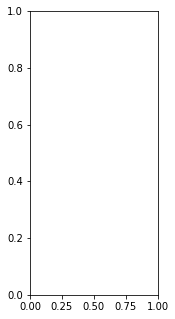

In [38]:
samples, labels=iter(train_loader).next()
classes={0:'cat',1:'dog'}
fig=plt.figure(figsize=(16,24))
for i in range(24):
  a=fig.add_subplot(4,6,i+1)
  a.set_title(classes[labels[i].item()])
  a.axis('off')
  a.imshow(np.transpose(samples[i].numpy(),(1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)


사전훈련된 모델 내려받기

In [ ]:
resnet18=models.resnet18(pretrained=True)

In [ ]:
def set_parameter_requires_grad(model, feature_extracting=True):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad=False

set_parameter_requires_grad(resnet18)

In [ ]:
resnet18.fc=nn.Linear(512,2)


In [ ]:
for name, param in resnet18.named_parameters():
  if param.requires_grad:
    print(name, param.data)

In [ ]:
model=models.resnet18(pretrained=True)

for param in model.parameters():
  param.requires_grad=False

model.fc=torch.nn.Linear(512,2)
for param in model.fc.parameters():
  param.requires_grad=True


optimizer=torch.optim.Adam(model.fc.parameters())
cost=torch.nn.CrossEntropyLoss()
print(model)

파일 저장

모델 학습을 위한 함수 생성 (5-20)

In [ ]:
def train_model(model, dataloaders,criterion, optimizer, device, num_epochs=13, is_train=True):
  since=time.time()
  acc_history=[]
  loss_history=[]
  best_acc=0.0

  for epoch in range(num_epochs):
    print('epoch{}/{}'.format(epoch, num_epochs-1))
    print('-'*10)

    running_loss=0.0
    running_corrects=0

    for inputs, labels in dataloaders:
      inputs=inputs.to(device)
      labels=labels.to(device)

      model.to(device)
      optimizer.zero_grad()
      outputs=model(inputs)
      loss=criterion(outputs, labels)
      _,preds=torch.max(outputs,1)
      loss.backward()
      optimizer.step()

      running_loss+=loss.item()*inputs.size(0)
      running_corrects+=torch.sum(preds==labels,data)


    epoch_loss=running_loss/len(dataloaders.dataset)
    epoch_acc=running_corrects.double()/len(dataloaders.dataset)

    print('loss: {:4f acc:{:.4f'.format(epoch_loss, epoch_acc))

    if epoch_acc>best_acc:
      best_acc=epoch_acc

    acc_history.append(epoch_acc.item())

    loss_history.append(epoch_loss)
    torch.save(model.state_dict(), os.path.join(''))  ############
    print()

  time_elapsed=time.time()-since
  print('training complete in {0:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
  print('best acc:{:4f'.format(best_acc))
  return acc_history, loss_history

In [ ]:
params_to_update=[]
for name, param in resnet18.named_parameters():
  if param.requires_grad==True:
    params_to_update.append(param)
    print("\t", name)

optimizer=optim.Adam(params_to_update)

In [ ]:
device=torch.device("cuda" if torch.cuda.os_available() else "cpu")
criterion=nn.CrossEntropyLoss()
train_Acc_hist, train_loss_hist=train_model(resnet18, train_loader, criterion, optimizer, device)

테스트 데이터 호출 및 전처리

In [ ]:
test_path=''  ##############33

transform=transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
test_dataset=torchvision.datasets.ImageFolder(
    root=test_path,
    traonsform=transform
)
test_loader=torch.utils.data.DataLoader(
  test_dataset,
  batch_size=32,
  num_workers=1,
  shuffle=True
)
print(len(test_dataset))



In [ ]:
def eval_model(model, dataloaders,device):
  since=time.time()
  acc_history=[]
  best_acc=0.0

  saved_models=glob.glob('')
  saved_odels.sort()
  print('saved_model', saved_models)

  for model_path in saved_models:
    print('loading model', model_path)

    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)
    running_corrects=0


    for inputs, labels in dataloaders:
      inputs=inputs.to(device)
      labels=labels.to(device)

      with torch.no_grad():
        outputs=model(inputs)


        -, preds=torch.max(outputs.data,1)
        preds[preds>=0.5]=1
        preds[preds<0.5]=0
        running_corrects+=preds.eq(labels.cpu()).int().sum()


    epoch_acc=running_corrects.double()/len(dataloaders.dataset)
    print('acc{:.4f'.format(epoch_acc))

    if epoch_acc > best_acc:
      best_acc=epoch_acc
      acc_history.append(epoch_acc.item())
      print()

    time_elapsed=time.time()-since
    print('training complete in {0:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('best acc:{:4f'.format(best_acc))
    return acc_history

In [ ]:
val_acc_hist=eval_model(resnet18, test_loader, device)

In [ ]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

In [ ]:
plt.plot(train_loss_hist)
plt.show()

In [ ]:
def im_convert(tensor):
  image=tensor.clone().detach().numpy()
  image=image.transpose(1,2,0)
  image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))
  image=image.clip(0,1)
  return image

개와 고양이 예측 결과 출력(5-29)

In [ ]:
classes={0:'cat',1:'dog'}

detaiter=iter(test_loader)
images,labels= dataiter.next()
output=model(images)
-,preds=torch.max(output,1)

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
  ax=fig.add_subplot(2,10,idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  a.set_title(classes[labels[i].item()])
ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[preds[idx].item()])), color=("green" if preds[idx]==labels[idx] else="red"))

plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

#설명가능한 cnn

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision

import torchvision.transforms as transforms
import torchvision.models as models

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

설명가능한 네트워크 생성

In [ ]:
model=XAI()
model.to(device)
model.eval()

In [ ]:
class LayerActivations:
  features=[]
  def __init__(self, model, layer_num):
    self.hook=model[layer_num].register_forward_hook(self.hook_fn)

  def hook_fn(self, module, input, output):
    self.featuers=output.detach().numpy()

  def remove(self):
    self.hook.remove()

In [ ]:
img=cv2.imread() ###########
plt.imshow(img)
img=cv2.resize(img, (100,100), interpolation=cv2.INTER_LINEAR)
img=ToTensor()(img).unsqueeze(0)
print(img.shape)

In [ ]:
result=LayerActivations(model.features,0)
model(img)
activations=result.features

In [ ]:
fig,axes=plt.subplots(4,4)
fig=plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for row in range(4):
  for column in range(4):
    axis=axes[row][column]
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])
    axis.imshow(activations[0][row*10+column])
plt.show()

In [ ]:
reuslt=LayerActivations(model.features,20)
model(img)
activations=result.features

In [ ]:
fig, axes=plt.subplots(4,4)
fig=plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
  for column in range(4):
    axis=axes[row][column]
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])
    axis.imshow(activations[0][row*10+column])
plt.show()

In [ ]:
result=LayerActivations(model.features,40)
model(img)
activations=result.features

In [ ]:
fig,axes=plt.subplots(4,4)
fig=plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hsapce=0.05, wspace=0.05)
for row in range(4):
  for column in range(4):
    axis=axes[row][column]
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])
    axis.imshow(activations[0][row*10+column])

plt.show()